In [1]:
from helpers import get_client, get_data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.lines as mlines

In [2]:
es = get_client()  
upload_latency_df = get_data("aggregated-curr-ulping-*", es)
download_latency_df = get_data("aggregated-curr-dlping-*", es)
idle_df = get_data("aggregated-curr-udplatency-*", es)


Connected to Elasticsearch.


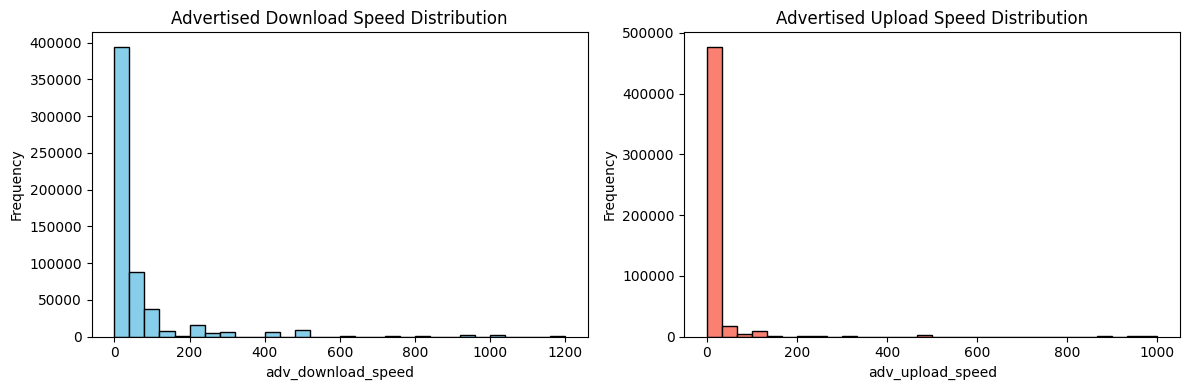

In [3]:
import matplotlib.pyplot as plt

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot for download_latency_df's adv_download_speed
axes[0].hist(download_latency_df['adv_download_speed'].dropna(), bins=30, 
             color='skyblue', edgecolor='black')
axes[0].set_title('Advertised Download Speed Distribution')
axes[0].set_xlabel('adv_download_speed')
axes[0].set_ylabel('Frequency')

# Plot for upload_latency_df's adv_upload_speed
axes[1].hist(upload_latency_df['adv_upload_speed'].dropna(), bins=30, 
             color='salmon', edgecolor='black')
axes[1].set_title('Advertised Upload Speed Distribution')
axes[1].set_xlabel('adv_upload_speed')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [4]:
upload_latency_df.head()

,unit_id,operator_name,operator_technology,adv_download_speed,adv_upload_speed,rtt_avg,rtt_max,rtt_min,rtt_std,date
0,8281,AT&T,DSL,6.0,0.768,599.868875,799.041875,16.922500,185.084625,2011-08-01T00:00:00+00:00
1,14646,AT&T,DSL,0.0,0.000,686.170695,860.814802,24.302276,214.712654,2011-09-01T00:00:00+00:00
2,7801,AT&T,DSL,3.0,0.512,352.526323,633.719599,37.764287,152.225041,2011-10-01T00:00:00+00:00
3,11163,Charter,Cable,12.0,1.000,548.823906,738.551509,57.993288,189.832869,2011-11-01T00:00:00+00:00
4,11936,Frontier,DSL,3.0,0.512,1305.527819,1743.113898,23.563137,418.711454,2011-12-01T00:00:00+00:00


In [16]:
def plot_latency(data, speed_tier: str):
    data = data.copy()
    if 'idle' in speed_tier:
        name = 'idle'
        speed_tier = speed_tier.split('|')[1]
    else:
        name = 'Upload' if 'upload' in speed_tier else 'Download'
    bins = [0, 50, 100, 200, 500, data[speed_tier].max()]
    labels = ['<50 Mbps', '50-100 Mbps', '100-200 Mbps', '200-500 Mbps', '500+ Mbps']

    data['speed_range'] = pd.cut(data[speed_tier], bins=bins, labels=labels, include_lowest=True)
    data['year'] = pd.to_datetime(data['date']).dt.year
    # data = data[data['year']>=2020]
    tmp = data[data['year']==2023]

    if name == 'Upload' or name == 'Download':
        box_title = f'Median Latency Under Load Versus Speed ({name}) - 2023'
    else:
        box_title = 'Median Idle Latency Versus Speed - 2023'

    # Chart 1: Boxplot (Latency by Speed Range)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='speed_range', y='rtt_avg', data=tmp, showfliers=False)
    plt.title(box_title)
    plt.xlabel(f'{name} Speed Range')
    plt.grid(True, axis='y')
    plt.ylabel('Latency (ms)')
    plt.tight_layout()
    plt.savefig(f'./plots/latency_vs_adv_speed/boxplot_{name.lower()}_2023.png')
    plt.show()

    # Chart 2: Heatmap of Median Latency by Year and Speed Range
    temp = data[data['year']>=2020]
    median_latency_yearly = temp.groupby(['year', 'speed_range'])['rtt_avg'].median().reset_index()
    pivot_heatmap_yearly = median_latency_yearly.pivot(index='year', columns='speed_range', values='rtt_avg')

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_heatmap_yearly, cmap='YlGnBu', annot=True, fmt='.1f', linewidths=.5)
    plt.title(f'Heatmap - Median Latency (ms) by Year and Advertised {name} Speed Range')
    plt.xlabel(f'{name} Speed Range')
    plt.ylabel('Year')
    plt.tight_layout()
    plt.savefig(f'./plots/latency_vs_adv_speed/heatmap_{name.lower()}.png')
    plt.show()

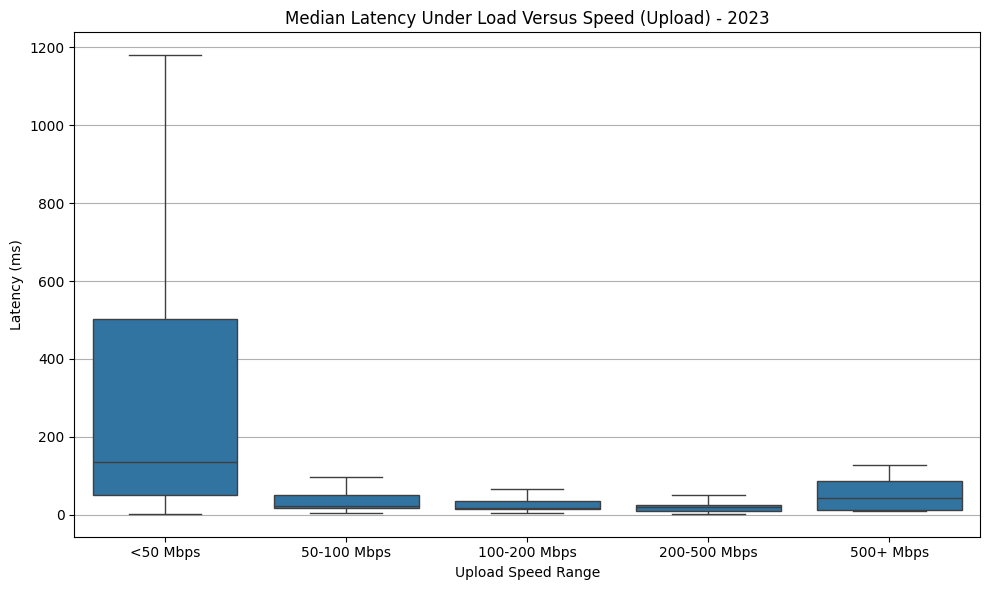

/tmp/ipykernel_112440/2239406317.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_latency_yearly = temp.groupby(['year', 'speed_range'])['rtt_avg'].median().reset_index()


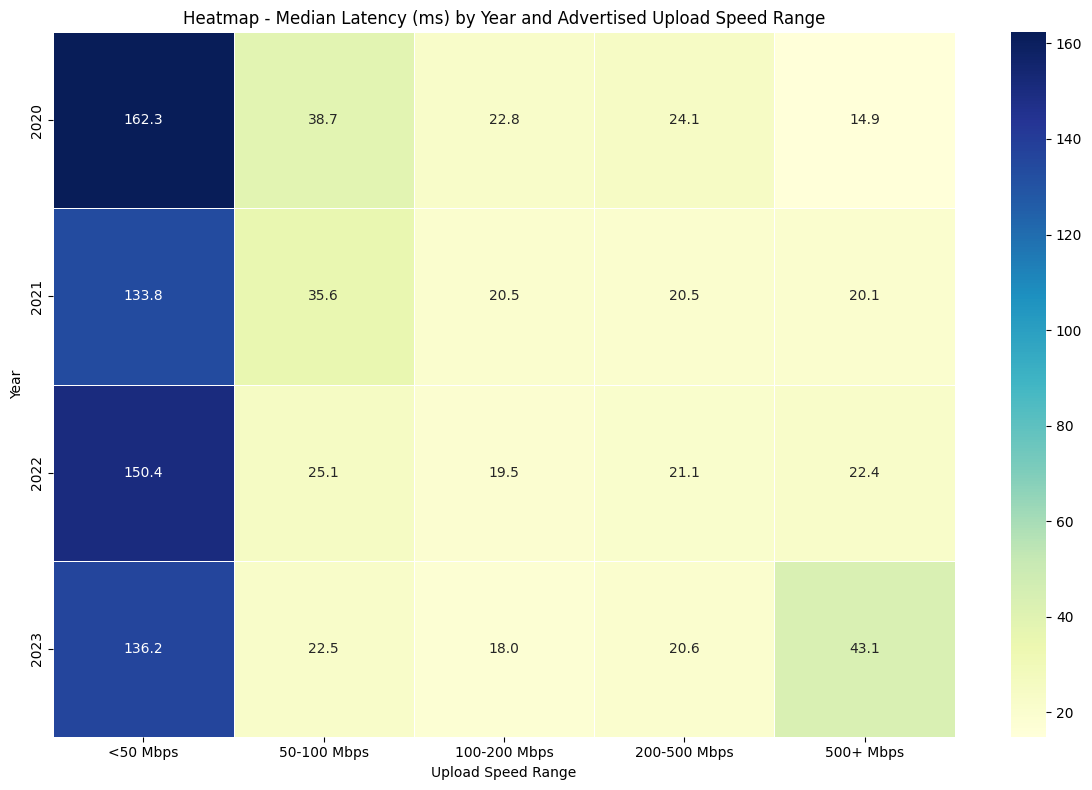

In [17]:
plot_latency(upload_latency_df, 'adv_upload_speed')

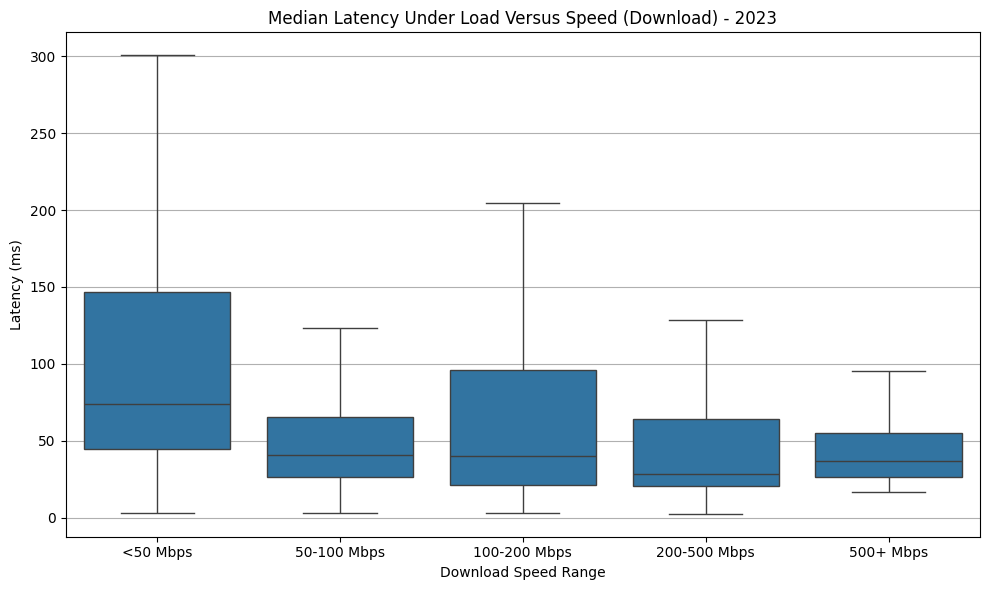

/tmp/ipykernel_112440/2239406317.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_latency_yearly = temp.groupby(['year', 'speed_range'])['rtt_avg'].median().reset_index()


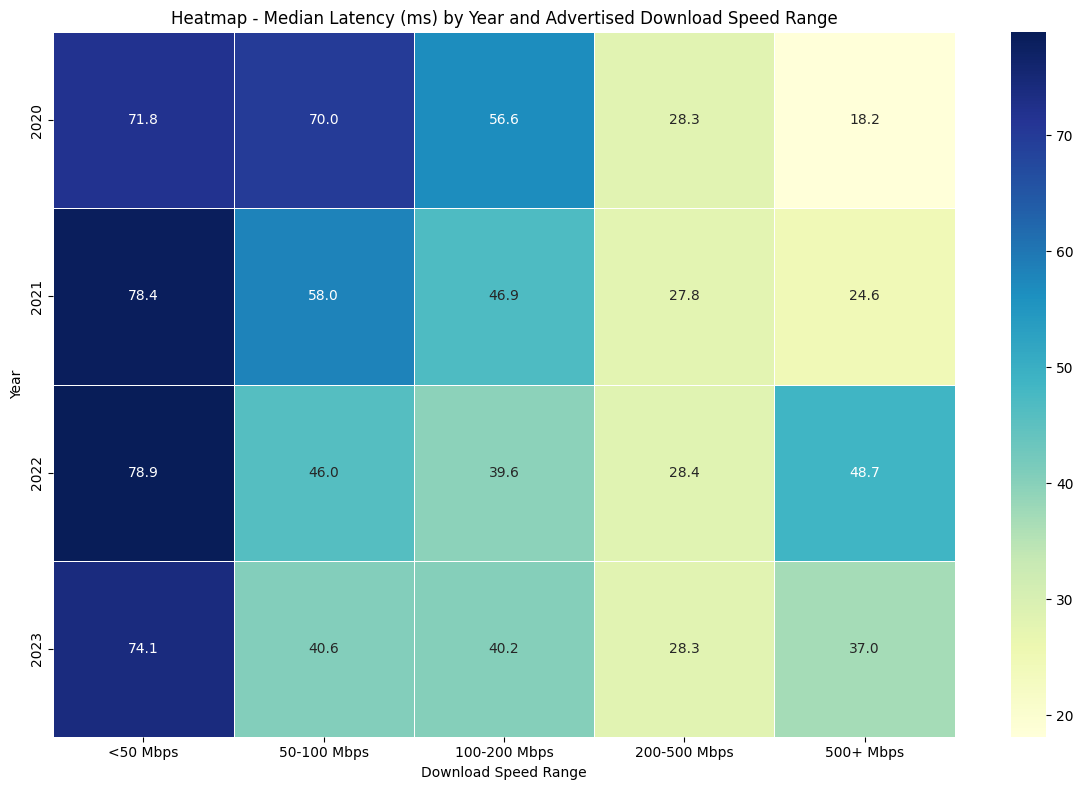

In [18]:
plot_latency(download_latency_df, 'adv_download_speed')

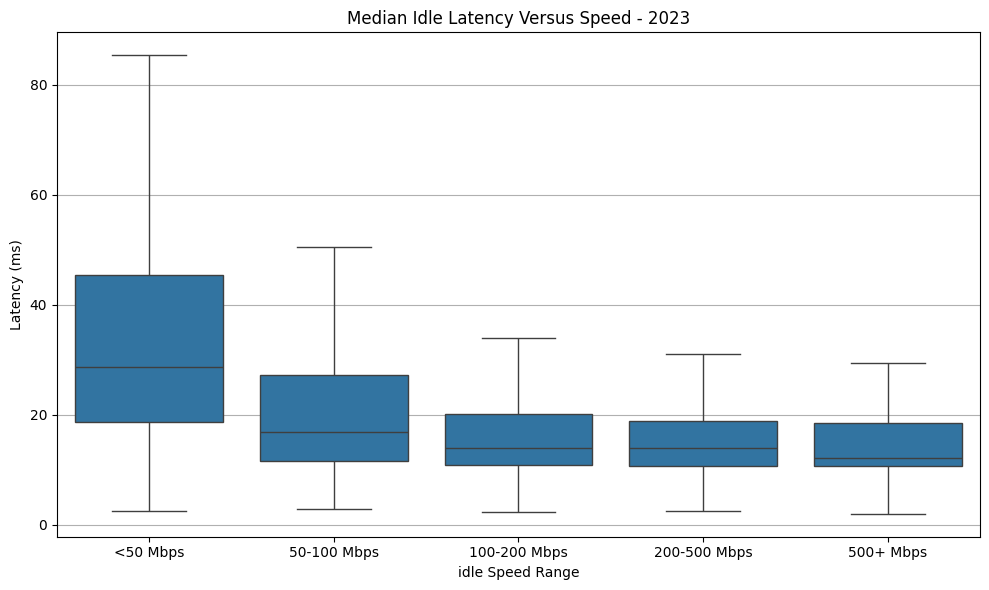

/tmp/ipykernel_112440/2239406317.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_latency_yearly = temp.groupby(['year', 'speed_range'])['rtt_avg'].median().reset_index()


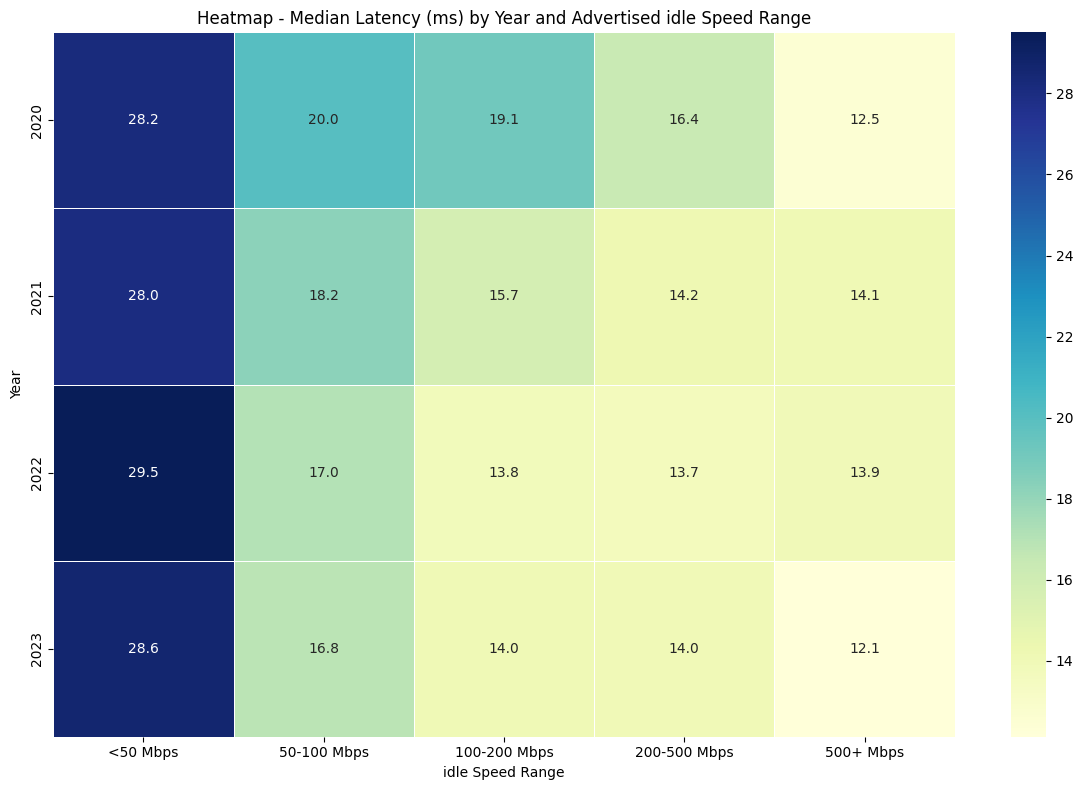

In [19]:
plot_latency(idle_df, 'idle|adv_download_speed')